[1. 1. 1. 1. 1. 1. 1.] 819.0 15558.0
71612 Total time steps used!
elapsed time: 70.68627010006458
[ 1127  1128  1129 ... 71572 71573 71574]
5632


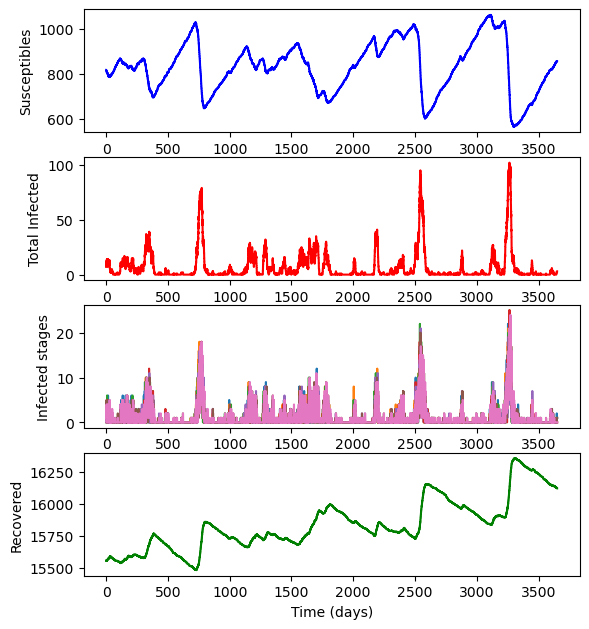

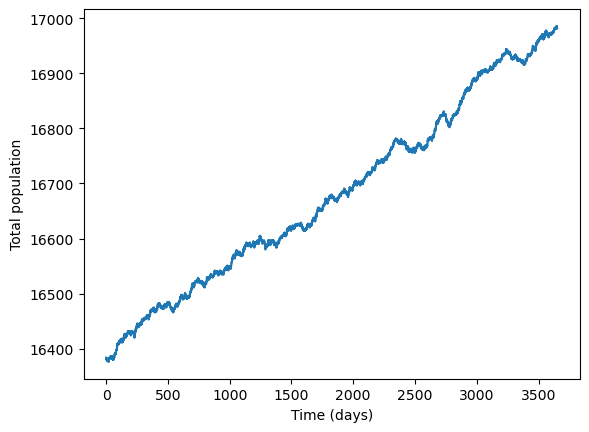

The disease went exinction at the points [1127, 1201, 1315, 4663, 9903, 10079, 10151, 10187, 10429, 10593, 10781, 10813, 10919, 11137, 11425, 11445, 11451, 11517, 19221, 19245, 19261, 19343, 19451, 19473, 19633, 19675, 19713, 19767, 19839, 19903, 20501, 20601, 20701, 20851, 20879, 24577, 24597, 24699, 26629, 27411, 27455, 27491, 27541, 28555, 28603, 28941, 29119, 29169, 36573, 36623, 38695, 38727, 38889, 38951, 39001, 39047, 39349, 39383, 40027, 40077, 40123, 40197, 40311, 40349, 40397, 40635, 43109, 43187, 43281, 43391, 43701, 45533, 45667, 54859, 54901, 55013, 55065, 55109, 55283, 55331, 55457, 55489, 55591, 55687, 55771, 55875, 55883, 55921, 55939, 55961, 56039, 56061, 56867, 56983, 57159, 57311, 57417, 57709, 57797, 60357, 60413, 60609, 69837, 69927, 69971, 70035, 70141, 70201, 70533, 70567, 70689, 70717, 70773, 70851, 70881, 71041, 71491, 71509]
Each extinction was for the corresponding time [57, 43, 25, 13, 115, 17, 7, 111, 27, 185, 9, 77, 105, 263, 5, 1, 25, 27, 9, 13, 61, 19, 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure
from tqdm import tqdm

gamma = 1
#mu is our death rate
mu = 1/(50 * 365)
N0 = 2**14
ND = MaxTime = 10 * 365
Number_Infection_States = 7
#we atm have uniform transition rates, this can be changed, but average infectious period formula will need to be changed
Rate_Transition = gamma
Average_Infectious_Period = ((1/gamma)*(Number_Infection_States-4)) + (1/gamma)
R0 = 5
beta = R0 * Average_Infectious_Period
#uses assumption atm that our population starts with all infected people just being infected - silly assumption
Infected_0 = np.ceil((mu * N0) /(gamma * Number_Infection_States)) * np.ones(Number_Infection_States)
Susceptible_0 = np.array((np.floor(gamma * N0 / beta)))
#Infected_0 = np.eye(Number_Infection_States)[0]
#Susceptible_0 = np.array((0.05 * N0))
Recovered_0 = np.array((N0 - Susceptible_0 - np.sum(Infected_0)))
print(Infected_0, Susceptible_0, Recovered_0)

#creates our input from our 3 arrays
INPUT = np.zeros((Number_Infection_States+2))
INPUT[0] = Susceptible_0
INPUT[-1] = Recovered_0
for m in range(Number_Infection_States):
    INPUT[m+1] = Infected_0[m]
    
death_toll = 0
birth_toll = 0

#print(INPUT)

timestep=0.0

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

import_counter = 0

def Stochastic_equations(INP,ts, Pop_Change): 
    #place to put rates associated with each population change
    Rate = np.zeros((4 + (3 * Number_Infection_States)))
    #This Matrix contains birth, all infections and infection transitions, recovery, death
    Total_Infections = np.sum(INP) - (INP[1] + INP[-1])
    #we assume only certain groups in the infectious period are actually infectious
    Total_Infectious_Population = np.sum(INP[int(1 + np.floor(Number_Infection_States * 3/7)): int(-1 - np.floor(Number_Infection_States * 3/7))])
    #total pop:
    N = np.sum(INP[0] + Total_Infections + INP[-1])
    #equation: birth
    Rate[0] = mu * N
    #equation: infection - need to make sure this puts susceptibles into first infection class
    Rate[1] = beta * INP[0] * Total_Infectious_Population / N
    #infection transitions
    Rate[2:(1+Number_Infection_States)] = Rate_Transition * INP[1: Number_Infection_States] * np.ones((Number_Infection_States-1))
    #equation: recovery
    Rate[1+Number_Infection_States] = gamma * INP[-2]
    #equation : recovered death
    Rate[2+Number_Infection_States] = mu * INP[-1]
    #equation: susceptible death
    Rate[3+Number_Infection_States] = mu * INP[0]
    #equations: infected deaths
    Rate[(4+Number_Infection_States):(4+(2*Number_Infection_States))] = mu * INP[1 : 1+Number_Infection_States] * np.ones((Number_Infection_States))
    #equation: imports
    Rate[4+(2*Number_Infection_States):4+(3*Number_Infection_States)] = np.sqrt(N) * np.ones((Number_Infection_States)) * 1/(5 * 365 * Number_Infection_States)
    #this is where the magic starts
    ts = -np.log(np.random.rand()) / (np.sum(Rate));
    m = min(find(np.cumsum(Rate) >= np.random.rand() * np.sum(Rate)));
    if Rate[m] == 0:
        for i in range(Number_of_Rules):
            if Rate[m] == 0:
                m +=1
    INP[range(2+ Number_Infection_States)] = INP[range(2 + Number_Infection_States)] + Pop_Change[m,:]
    global death_toll
    global birth_toll
    if m >= 2+Number_Infection_States and m < (4+(2*Number_Infection_States)):
        death_toll += 1
    if m ==0:
        birth_toll += 1
    return [INP,ts]

def Stochastic_iteration(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([0])
    I = np.zeros((1, Number_Infection_States))
    R = np.array([0])
    #this matrix was originally in the stochastic equations, but takes quite alot of work to create, so I put it here to speed up the program
    Pop_Change_Matrix = np.reshape(np.append(np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -1)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -(Number_Infection_States + 3))\
    , np.eye(2 + Number_Infection_States)[1:-1]), [4 + ( 3* Number_Infection_States), 2 + Number_Infection_States])
    while T[counter] < ND:
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        [res,ts] = Stochastic_equations(INPUT,ts, Pop_Change_Matrix)
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        #print(T, S, I, R)
        #print(counter, T[counter])
    print(counter, "Total time steps used!")
    return [T,S,I,R]

start = timer()
[T,S,I,R]=Stochastic_iteration(INPUT)
end = timer()

print(f'elapsed time: {end - start}')

tT=np.array(T)[1:,]
tS=np.array(S)[1:,]
tI=np.array(I)[1:,]
tR=np.array(R)[1:,]
ttI = tI.sum(axis=1)

zero_points = np.where(ttI == 0)
zero_points = zero_points[0]
print(zero_points)
print(np.size(zero_points))

#def ttI_analysis(tti):

plt.subplot(4, 1, 1)
plt.plot(tT, tS, 'b')
plt.ylabel ('Susceptibles')
plt.subplot(4, 1, 2)
plt.plot(tT, ttI, 'r')
plt.ylabel ('Total Infected')
plt.subplot(4, 1, 3)
plt.plot(tT, tI)
plt.ylabel ('Infected stages')
plt.subplot(4, 1, 4)
plt.plot(tT, tR, 'g')
plt.xlabel ('Time (days)')
plt.ylabel ('Recovered')
plt.gcf().subplots_adjust(bottom=-0.3)
plt.savefig('Gil 4 fig')
plt.show()

plt.plot(tT, tS+ttI+tR)
plt.xlabel ('Time (days)')
plt.ylabel ('Total population')
plt.savefig('Total Gil Pop')
plt.show()

#code to calculate where the disease goes extinct and how long for
if np.size(zero_points) > 0:
    extinction_points = [zero_points[0]]
    extinction_lengths = []
    extinction_timer = 0
    for i in range(len(zero_points)-1):
        if zero_points[i] != zero_points[i+1] - 1:
            extinction_points.append(zero_points[i+1])
            extinction_lengths.append(extinction_timer)
            extinction_timer = 0
        else:
            extinction_timer += 1
    extinction_lengths.append(extinction_timer)
    print("The disease went exinction at the points", extinction_points)
    print("Each extinction was for the corresponding time", extinction_lengths)
    
print("There was a total of ", birth_toll, " births.")
print("and ", death_toll, " deaths")

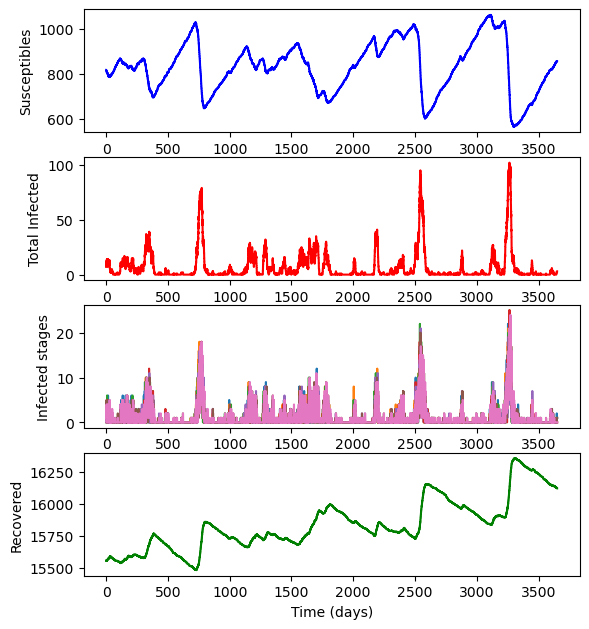

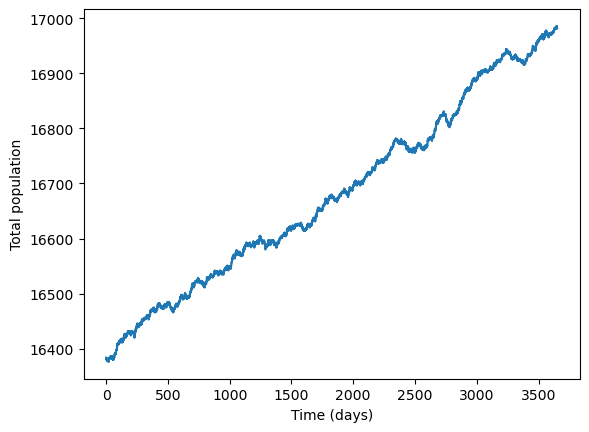

Our extinction rate was 0.03232876712328767


In [2]:
plt.subplot(4, 1, 1)
plt.plot(tT, tS, 'b')
plt.ylabel ('Susceptibles')
plt.subplot(4, 1, 2)
plt.plot(tT, ttI, 'r')
plt.ylabel ('Total Infected')
plt.subplot(4, 1, 3)
plt.plot(tT, tI)
plt.ylabel ('Infected stages')
plt.subplot(4, 1, 4)
plt.plot(tT, tR, 'g')
plt.xlabel ('Time (days)')
plt.ylabel ('Recovered')
plt.gcf().subplots_adjust(bottom=-0.3)
plt.savefig('Gil 4 fig.png')
plt.show()

plt.plot(tT, tS+ttI+tR)
plt.xlabel ('Time (days)')
plt.ylabel ('Total population')
plt.savefig('Total Gil Pop.png')
plt.show()

extinction_rate = len(extinction_points)/ND
print("Our extinction rate was", extinction_rate)